In [1]:
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from efficientnet.keras import EfficientNetB5
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

from glob import glob
import pandas as pd
import numpy as np
import random
import cv2
import os

Using TensorFlow backend.


In [2]:
path = "data\\dataset"
train_path = path + "\\train"
test_path = path + "\\test"

In [3]:
numberOfClasses = len(glob(train_path + "\\*"))

numberOfClasses

4

In [4]:
batch_size = 2

size = 160

# Data Augmentation 

In [5]:
train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                   zoom_range=0.3)

test_datagen = ImageDataGenerator()

# Flow From Directory

In [6]:
train_datagen = train_datagen.flow_from_directory(directory=train_path,
                                                  target_size=(size, size),
                                                  class_mode='categorical',
                                                  batch_size=batch_size, 
                                                  shuffle=True)

test_datagen = test_datagen.flow_from_directory(directory=test_path,
                                                target_size=(size, size),
                                                class_mode='categorical',
                                                batch_size=batch_size, 
                                                shuffle=True)

Found 83484 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [7]:
train_datagen[0][0].shape

(2, 160, 160, 3)

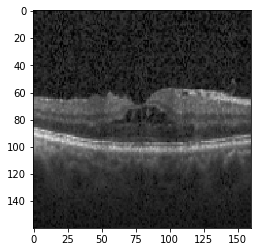

In [8]:
plt.imshow(train_datagen[0][0][0]/255);

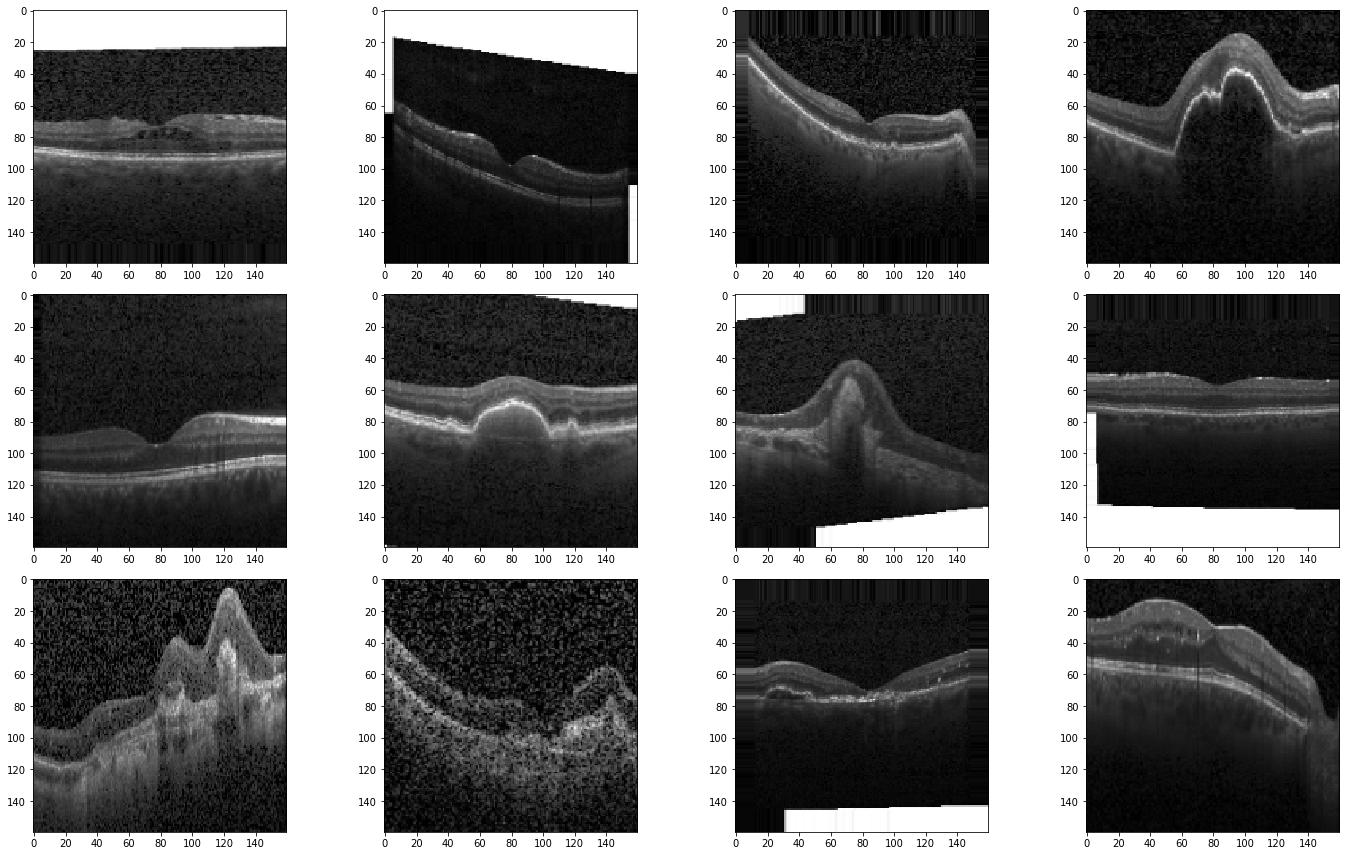

In [9]:
fig = plt.figure(figsize=(20,12))

for im in range(12):
    img = train_datagen[im][0][0]/255
    fig.add_subplot(3,4,im+1)
    plt.imshow(img)
    
plt.tight_layout()

# Callbacks

In [10]:
lr = ReduceLROnPlateau(monitor="val_loss", 
                       factor=0.3, 
                       patience=5, 
                       verbose=1, 
                       mode="max")

cp = ModelCheckpoint(filepath="data/model/effiency_model.{epoch:02d}-{val_loss:.2f}.h5", 
                     save_best_only=True)

# Transfer Learning

--> This is multi classes problem, therefore I need to use "softmax"

In [11]:
model = Sequential()
model.add(EfficientNetB5(include_top=False, input_shape=(size,size,3)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(numberOfClasses, activation="softmax"))


model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Training

In [12]:
hist = model.fit_generator(generator=train_datagen, 
                           steps_per_epoch=train_datagen.n//(batch_size*60), 
                           validation_data=test_datagen,
                           validation_steps=test_datagen.n//(batch_size*60), 
                           callbacks=[lr, cp],
                           epochs=8)

Instructions for updating:
Use tf.cast instead.
Epoch 1/8
695/695 [==============================] - 235s 338ms/step - loss: 1.0915 - acc: 0.6000 - val_loss: 1.0153 - val_acc: 0.5000
Epoch 2/8
695/695 [==============================] - 198s 285ms/step - loss: 0.8432 - acc: 0.6942 - val_loss: 1.9562 - val_acc: 0.5000
Epoch 3/8
695/695 [==============================] - 199s 287ms/step - loss: 0.7843 - acc: 0.7281 - val_loss: 2.4859 - val_acc: 0.4375
Epoch 4/8
695/695 [==============================] - 199s 286ms/step - loss: 0.6705 - acc: 0.7885 - val_loss: 0.5246 - val_acc: 0.7500
Epoch 5/8
695/695 [==============================] - 199s 286ms/step - loss: 0.6251 - acc: 0.7799 - val_loss: 0.3808 - val_acc: 0.8750
Epoch 6/8
695/695 [==============================] - 201s 289ms/step - loss: 0.6074 - acc: 0.7978 - val_loss: 0.7898 - val_acc: 0.8750
Epoch 7/8
695/695 [==============================] - 200s 288ms/step - loss: 0.5777 - acc: 0.8086 - val_loss: 0.2734 - val_acc: 0.8125
Epoch 8

# Visualization

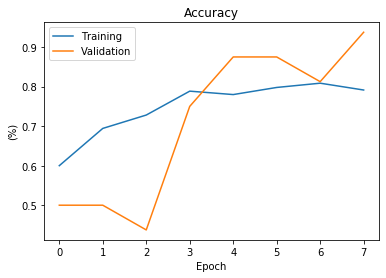

In [13]:
plt.plot(hist.history["acc"])
plt.plot(hist.history["val_acc"])
plt.legend(["Training", "Validation"])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("(%)");

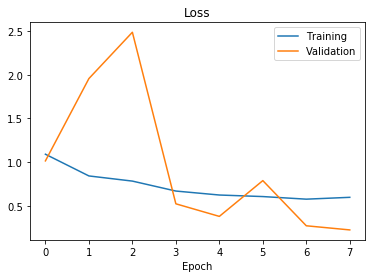

In [14]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("Loss")
plt.xlabel("Epoch");

----

# Visualization 

for ROC Curve and Confusion Matrix, I need to get data. First I used keras to get data but it doesn't work for visualization

In [15]:
file = os.listdir(test_path)

file

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [16]:
test_data = []
test_label = []

for classes in file:
    path = test_path + "\\" + classes
    print(path)
    
    for img in glob(path + "\\*"):
        # for images
        img = cv2.imread(img)
        img = cv2.resize(img, (size,size))
        img = img.astype("float32")
        
        # for classification
        if classes == "CNV":
            label = 0
        elif classes == "DME":
            label = 1
        elif classes == "DRUSEN":
            label = 2
        else:
            label = 3
            
        # append to list
        test_data.append(img)
        test_label.append(label)

data\dataset\test\CNV
data\dataset\test\DME
data\dataset\test\DRUSEN
data\dataset\test\NORMAL


In [17]:
test_data[0].shape

(160, 160, 3)

In [18]:
X_test = np.asarray(test_data)

X_test.shape

(1000, 160, 160, 3)

In [19]:
y_test = np.asarray(test_label)

y_test.shape

(1000,)

# Confusion Matrix

In [20]:
y_true = y_test
y_pred = model.predict_classes(X_test)
y_probas = model.predict(X_test)

In [21]:
index = [0, 333, 500, 666, 999]
for idx in index:
    print(f"""
          index : {idx}
          y_true : {y_true[idx]}
          y_pred : {y_pred[idx]}
          y_probas : {y_probas[idx]}
          """)


          index : 0
          y_true : 0
          y_pred : 0
          y_probas : [0.95826757 0.01219599 0.02536696 0.00416946]
          

          index : 333
          y_true : 1
          y_pred : 1
          y_probas : [4.128641e-02 9.587005e-01 3.430629e-06 9.663996e-06]
          

          index : 500
          y_true : 2
          y_pred : 2
          y_probas : [1.5480260e-03 6.5090092e-08 9.9845195e-01 4.1196916e-08]
          

          index : 666
          y_true : 2
          y_pred : 2
          y_probas : [5.4094452e-02 2.7176666e-05 9.4585079e-01 2.7552927e-05]
          

          index : 999
          y_true : 3
          y_pred : 3
          y_probas : [0.00492538 0.03124531 0.04427622 0.91955304]
          


In [22]:
cm = confusion_matrix(y_true, y_pred)

cm

array([[236,  11,   2,   1],
       [ 30, 219,   0,   1],
       [  8,   0, 233,   9],
       [  0,   2,   0, 248]], dtype=int64)

In [23]:
cm = pd.DataFrame(cm, 
                  columns=['CNV', 'DME', 'DRUSEN', 'NORMAL'], 
                  index=['CNV', 'DME', 'DRUSEN', 'NORMAL'])

cm

,CNV,DME,DRUSEN,NORMAL
CNV,236,11,2,1
DME,30,219,0,1
DRUSEN,8,0,233,9
NORMAL,0,2,0,248


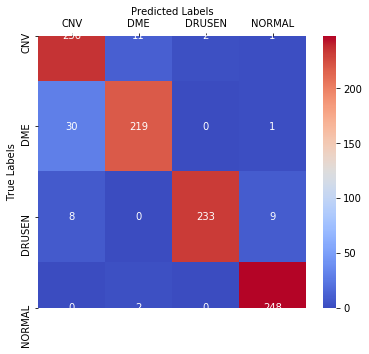

In [24]:
plt.figure(figsize=(6,5))

hm = sns.heatmap(cm, 
                 annot=True, 
                 fmt="n",cmap="coolwarm")

hm.tick_params(labeltop=True, 
               labelbottom=False, 
               top=True,
               bottom=False)

hm.set_xlabel("Predicted Labels")
hm.xaxis.set_label_position("top")

hm.set_ylabel("True Labels");

# ROC Curve

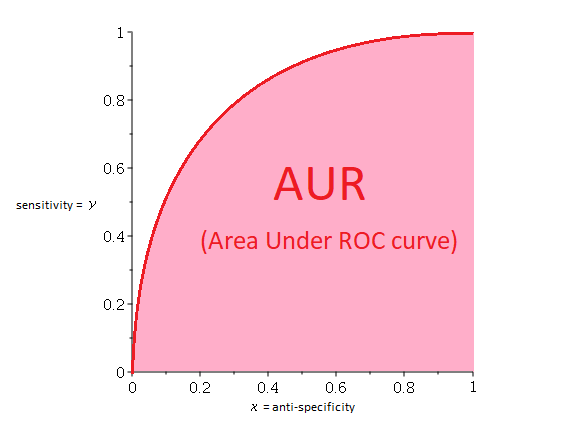

ROC Curve is used for that evaluate the perform of binary algoritms. 
It shows how successfully the model difference between classes.

**True Positive : TP**

**False Positive : FP**

**True Negative : TN**

**False Negative : FN**

**Sensitivity : True Positive Rate : TPR**

**Specificity : True Negative Rate : TNR**


---

**False Positive Rate (FPS) : (FP / (TN + FP))**

**True Negative Rate (TNS) : (TN / (TN + FP))**

**1 = ((TN + FP) / (TN + FP))**

**1 - Specificity = False Positive Rate**

<Figure size 504x504 with 0 Axes>

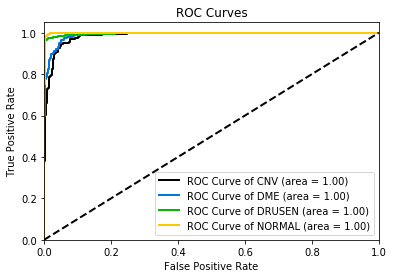

In [25]:
plt.figure(figsize=(7,7))

skplt.metrics.plot_roc(y_true, 
                       y_probas, 
                       plot_macro=False, 
                       plot_micro=False)

plt.legend(["ROC Curve of CNV (area = 1.00)",
            "ROC Curve of DME (area = 1.00)",
            "ROC Curve of DRUSEN (area = 1.00)",
            "ROC Curve of NORMAL (area = 1.00)"], loc="lower right");

# Save Weights

In [26]:
open("data/model/weights/model.json","w").write(model.to_json())
model.save_weights("data/model/weights/model.h5")